In [ ]:
!apt install unzip

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# IMPORT LIB


In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import glob as gb
import splitfolders
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import pandas as pd
from IPython.display import Image
import tensorflow as tf
import tensorflow_hub as hub
from keras.callbacks import ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/DATA _SCV/train.zip" > /dev/null

In [ ]:
!unzip "/content/drive/MyDrive/DATA _SCV/test.zip" > /dev/null

# SPLIT TRAIN, VAL

In [ ]:
input_folder ="/content/seg_train"
output = "/content/output"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.7,0.3),group_prefix=None)

Copying files: 14034 files [00:02, 6730.02 files/s]


#  MODELS

## INCEPTION

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3

In [ ]:
train_DIR = "/content/output/train"

train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          vertical_flip=True,
                                          fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

val_DIR = "/content/output/val"
validation_datagen = ImageDataGenerator(rescale = 1.0/255)


validation_generator = validation_datagen.flow_from_directory(val_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


Found 9820 images belonging to 6 classes.
Found 4214 images belonging to 6 classes.


In [ ]:
inceptionV3 = InceptionV3(include_top= False, input_shape=(150,150,3))

for layer in inceptionV3.layers:
	layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
last_layer = inceptionV3.get_layer('mixed9')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 1024, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units = 2048, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.19)(x)
x = tf.keras.layers.Dense  (6, activation = tf.nn.softmax)(x)

model1 = tf.keras.Model( inceptionV3.input, x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

filepath = "model_{epoch:02d}-{val_acc:.2f}.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

model1.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

model1.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
history = model1.fit(train_generator,
                    epochs = 20,
                    verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction,callbacks_list])

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.5621 - acc: 0.8013
Epoch 1: val_acc improved from -inf to 0.89321, saving model to model_01-0.89.h5
77/77 [==============================] - 75s 817ms/step - loss: 0.5621 - acc: 0.8013 - val_loss: 0.2879 - val_acc: 0.8932 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.3971 - acc: 0.8560
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 2: val_acc did not improve from 0.89321
77/77 [==============================] - 57s 743ms/step - loss: 0.3971 - acc: 0.8560 - val_loss: 0.3038 - val_acc: 0.8768 - lr: 0.0010
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.3169 - acc: 0.8831
Epoch 3: val_acc improved from 0.89321 to 0.90532, saving model to model_03-0.91.h5
77/77 [==============================] - 59s 771ms/step - loss: 0.3169 - acc: 0.8831 - val_loss: 0.2569 - val_acc: 0.9053 - lr: 2.5000e-04
Epoch 4/20
77/77 [==================

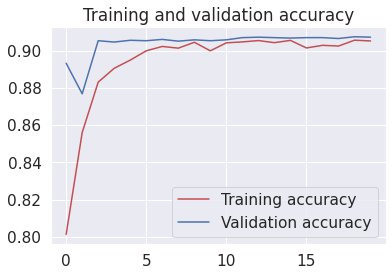

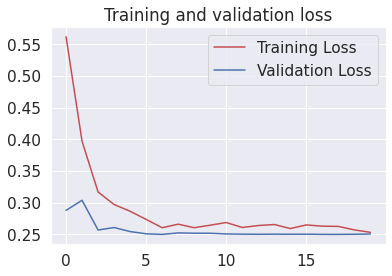

In [ ]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# PREDICTION


In [ ]:
pred_csv=pd.DataFrame(columns=['id','label'])

In [ ]:
path="/content/test"

pred_file_path=[]
id=[]
for i in os.listdir(path):
    id.append(i)
    pred_file_path.append(path+'/'+i)
print(pred_file_path)
pred_csv['id']=id

['/content/test/2855.jpg', '/content/test/135.jpg', '/content/test/1045.jpg', '/content/test/2304.jpg', '/content/test/1270.jpg', '/content/test/491.jpg', '/content/test/1881.jpg', '/content/test/2073.jpg', '/content/test/646.jpg', '/content/test/173.jpg', '/content/test/556.jpg', '/content/test/2212.jpg', '/content/test/669.jpg', '/content/test/1945.jpg', '/content/test/1747.jpg', '/content/test/2522.jpg', '/content/test/2032.jpg', '/content/test/991.jpg', '/content/test/1931.jpg', '/content/test/1136.jpg', '/content/test/2815.jpg', '/content/test/1428.jpg', '/content/test/825.jpg', '/content/test/284.jpg', '/content/test/212.jpg', '/content/test/502.jpg', '/content/test/2761.jpg', '/content/test/126.jpg', '/content/test/86.jpg', '/content/test/2858.jpg', '/content/test/2315.jpg', '/content/test/2899.jpg', '/content/test/2635.jpg', '/content/test/2743.jpg', '/content/test/1310.jpg', '/content/test/847.jpg', '/content/test/2234.jpg', '/content/test/259.jpg', '/content/test/1729.jpg', '

In [ ]:
len(pred_file_path)

3000

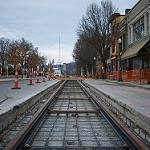

In [ ]:
Image(pred_file_path[2995])


In [ ]:
def tensor(fp):
  image=tf.io.read_file(fp) #or we can use plt.imread(fp)
  image=tf.image.decode_jpeg(image,3) #or we can use image=tf.constant(image)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,(150,150))
  return image

In [ ]:
BATCH_SIZE=16

def data_batches(X,y=None,batch_size=BATCH_SIZE,test_data=False,prediction_data=False):
  if prediction_data:
    print("pred_data")
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X)) #we use this unbatch the data
    data=data.map(tensor).batch(BATCH_SIZE)    # we use this to map and bacth data of batch_size=2
    return data

In [ ]:
pred_data=data_batches(pred_file_path,prediction_data=True)
len(pred_data)

pred_data


188

In [ ]:
pred_predictions=model1.predict(pred_data,verbose=1)

188/188 [==============================] - 6s 22ms/step


In [ ]:
class_name=list(train_generator.class_indices.values())
class_name

[0, 1, 2, 3, 4, 5]

In [ ]:
train_generator.class_indices


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
classify=[]
for i in pred_predictions:
    for j in range(6):
        if i[j]==max(i):
            classify.append(class_name[j])

In [ ]:
pred_csv['label']=classify

In [ ]:
pred_csv

,id,label
0,2855.jpg,4
1,135.jpg,3
2,1045.jpg,1
3,2304.jpg,2
4,1270.jpg,5
...,...,...
2995,151.jpg,0
2996,2046.jpg,2
2997,2559.jpg,2
2998,2695.jpg,0


In [ ]:
pred_csv['id']=pred_csv['id'].str.replace('.jpg','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
pred_csv['id']=pred_csv['id'].astype('int64',copy=False)

In [ ]:
pred_csv=pred_csv.sort_values(by='id', ascending=True)


In [ ]:
pred_csv.to_csv ('DL10.csv', index = False)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


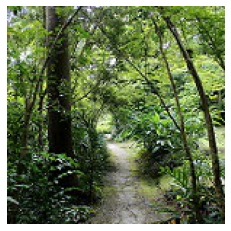

In [ ]:
# Visualize
img = load_img('/content/test/1175.jpg')
plt.imshow(img)
plt.axis("off")
plt.show()